# Анализ параметров 2

In [1]:
from analys.energy import Staticstics
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class atom():
    '''
    Параметры конкретного атома
    '''
    def __init__(self, 
                 data,
                 molecule = 0, 
                 atom = 0,
                 **kwargs):
        
        self.molecule = molecule
        self.atom = atom
        self.coord = self.get_matrix(data, 0)
        self.vel = self.get_matrix(data, 1)
        
    def get_matrix(self, data, delta):
        ''' 
        deltadelta = 0 --- coordinates
        delta = 1 --- velocities
        molecule/atom --- numbers 0,1
        '''
        start_index = self.molecule * 12 + self.atom * 6 + delta
        
        v1 = []
        for ind in range(start_index, start_index + 6, 2):
            v1.append(data[ind])
        
        return np.array(v1)

In [3]:
class molecule():
    def __init__(self,
                 data,
                 molecule=0, 
                 k=105734.2419441007825, 
                 unstretched = 0.32932330827068):
        '''
        > Параметры:
        >>> k - жесткость "пружины" в молекуле;
        >>> unstretched --- расстояние между атомами при релаксации;
        '''
        self.k = k
        self.unstretched = unstretched
        self.atom0 = atom(data, molecule, 0)
        self.atom1 = atom(data, molecule, 1)
        self.vel = self.center_molecular_vel()
        self.coord = self.center_molecular_coord()
        self.M = 2.
        
    def center_molecular_vel(self):
        return (self.atom0.vel + self.atom1.vel) / 2.
    
    def center_molecular_coord(self):
        return (self.atom0.coord + self.atom1.coord) / 2.

    def interatomic_distance(self):
        return np.sqrt(np.sum((self.atom0.coord - self.atom1.coord) ** 2, axis = 0))
        
    def V_in(self):
        '''
        Потенциальная энергия V = k * (r - r0)^2
        '''
        dist = self.interatomic_distance()
    
        return self.k * ((dist - self.unstretched) ** 2)
    

    def T(self, mv = 0.0):
        '''
        Кинетическая энергия молекулы T = v^2/2
        Параметры:
        >>> mv --- скорость центра масс системы,
        >>> (т.е. для подсчёта без неё)
        '''
        vel0 = self.atom0.vel - mv
        vel1 = self.atom1.vel - mv
        return  0.5  *(np.sum(vel0 ** 2, axis = 0) + np.sum(vel1 ** 2, axis = 0))
    
    def T_c(self, mv = 0.0):
        '''
        Кинетическая энергия центра масс молекулы
        '''
        return self.M * np.sum((self.vel - mv) ** 2, axis = 0) / 2.

    def T_in(self, mv = 0.0):
        '''
        Внутренняя кинетическая энергия молекулы
        '''
        # остались скорости
        v1 = self.atom0.vel - self.vel
        v2 = self.atom1.vel - self.vel
        return np.sum(v1 **2 + v2 **2, axis = 0)/2
        
    
    def Full_Energy(self, mv=0.0):
        ''' 
        полная энергия в молекуле
        '''
        return self.T(mv) + self.V_in()
    
    
    def Divided_energy(self):
        '''
        Разделим энергию на составляющие: forward, vibrational, rational 
        '''
        
        forward = self.M * np.sum(self.vel * self.vel, axis = 0) / 2.
        
        # остались скорости
        v1 = self.atom0.vel - self.vel
        v2 = self.atom1.vel - self.vel
        T_in = np.sum(v1 **2 + v2 **2, axis = 0)/2
        
        # найдём вектор между двумя атомами
        vec = self.atom1.coord - self.atom0.coord
        dist = self.interatomic_distance()
        # проецируем скорости на этот вектор 
        v1_pr = (np.sum(v1 * vec, axis=0) / dist) * (vec / dist )
        v2_pr = (np.sum(v2 * vec, axis=0) / dist) * (vec / dist)

        #колебательная энергия
        vibrational = np.sum((v1_pr * v1_pr + v2_pr * v2_pr), axis = 0) / 2.0 + self.V_in()
        
        v1_r = v1 - v1_pr
        v2_r = v2 - v2_pr
        rational = np.sum((v1_r * v1_r + v2_r * v2_r)/2.0, axis = 0) 

        return forward, rational, vibrational

In [4]:
class molecular_system():
    def __init__(self, data, 
                 k=105734.2419441007825, 
                 unstretched = 0.32932330827068):
        
        self.m0 = molecule(data, 0, k, unstretched)
        self.m1 = molecule(data, 1, k, unstretched)
        self.vel = self.center_vel()
        self.coord = self.center_coord()
        self.M = 4.
        self.m_r = (2. * 2.)/ (2.+2.)
        self.c_r = self.relative_velocity()
        
    def center_vel(self):
        '''
        Скорость центра масс системы
        '''
        return (self.m0.vel + self.m1.vel) / 2.
    
    def center_coord(self):
        '''
        Координаты центра масс системы
        '''
        return (self.m0.coord + self.m1.coord) / 2.

    def intermolecular_distance(self):
        '''
        Расстояние между молекулами
        '''
        return np.sqrt(np.sum((self.m0.coord - self.m1.coord) ** 2, axis = 0))    

    def relative_velocity(self):
        '''c_r'''
        return self.m1.vel - self.m0.vel
    
    def relative_velocity_len(self):
        '''c_r'''
        return np.sqrt(np.sum(self.c_r ** 2, axis = 0))

    
    @staticmethod
    def dist2(ri,rj):
        ''' Расстояние между атомами '''
        return np.sum((ri - rj)**2, axis=0)

    
    def V_in(self):
        return self.m0.V_in() +  self.m1.V_in()
    
    
    def LD(self):
        '''
        Потенциал ЛД
        '''
        result = 0.0
        
        dist = self.dist2(self.m0.atom0.coord,self.m1.atom0.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
        
        dist = self.dist2(self.m0.atom0.coord,self.m1.atom1.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
        
        dist = self.dist2(self.m0.atom1.coord,self.m1.atom0.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
        
        dist = self.dist2(self.m0.atom1.coord,self.m1.atom1.coord)
        result += 1 / (dist ** 6) - 1 / (dist ** 3)
                
        return 4 * result

    def Full_Energy(self):
        '''
        Полная энергия системы
        '''
        return self.m0.Full_Energy() + self.m1.Full_Energy()  + self.LD()
    
    
    def Full_Energy_r(self):
        '''
        Полная энергия системы за вычетом Кинетической энергии движения центра масс системы
        '''
        return self.Full_Energy() - self.T_c()  #self.m0.V_in() + self.m1.V_in()  + self.LD() +self.T_r()
    
    def Full_Energy_rt(self):
        '''
        Полная энергия системы за вычетом Кинетической энергии движения центра масс системы
        и внутренней кинетической энергии молекулы
        '''
        return self.Full_Energy() - self.T_c() - self.T_in() #self.m0.V_in() + self.m1.V_in()  + self.LD() +self.T_r()

    def T_r(self):
        '''
        Кинетическая энергия отнсительнго движения
        '''
        return self.m_r * np.sum((self.c_r  ** 2), axis=0) / 2.
    
    #def T_r(self):
    #    '''
    #    Кинетическая энергия отнсительнго движения
    #    '''
    #    return self.m_r * np.sum(((self.c_r - self.vel)  ** 2), axis=0) / 2.
    
    def T_c(self):
        '''
        Кинетическая энергия центра масс системы
        '''
        return self.M * np.sum( (self.vel ** 2) , axis = 0)/ 2.

    
    def T_in(self):
        ''' 
        Внутренняя кинетическая энергия молекулы
        '''
        return self.m0.T_in() + self.m1.T_in() 
        
    def T(self):
        '''
        Полная кинетическая энергия системы
        '''
        return self.m0.T() + self.m1.T() 
    
    def Divided_energy(self):
        forward, rational, vibrational = self.m0.Divided_energy()
        forward1, rational1, vibrational1 = self.m1.Divided_energy()
        return forward + forward1, rational + rational1, vibrational + vibrational1
    
    def length_vel(self):
        return np.sqrt(np.sum(self.c_r ** 2, axis = 0))

In [5]:
class calc_system():
    def __init__(self, 
                 aiming = "0.00", num = "0", PATH =  "1/out_8/",
                 k=105734.2419441007825, 
                 unstretched = 0.32932330827068):
        
        data_init, data_end = self.get_data(aiming, num, PATH)
        self.s1 = molecular_system(data_init, k, unstretched)
        self.s2 = molecular_system(data_end, k, unstretched)
        
    @staticmethod
    def to_num(init):
        for i in range(24):
            init[i] = pd.to_numeric(init[i])        
        return init    
    
    def get_data(self, aiming, num, PATH):
        init = pd.read_csv(PATH + 'aiming_{0}/init/file_{1}.csv'.format(aiming, num), sep='\t',header=None)
        end = pd.read_csv(PATH + 'aiming_{0}/LF/file_{1}.csv'.format(aiming, num), sep='\t',header=None)

        del init[24]
        del end[24]

        init = init[~init.isin([np.nan, np.inf, -np.inf, "-nan(ind)"]).any(1)]
        end = end[~end.isin([np.nan, np.inf, -np.inf, "-nan(ind)"]).any(1)]
        init, end = self.to_num(init), self.to_num(end)
        return init, end

    def angle(self):
        return np.mean(np.abs(np.sum(self.s1.c_r * self.s2.c_r, axis = 0)/(self.s1.length_vel() * self.s2.length_vel())))
    
    def diff_c_r(self):
        return self.s1.vel - self.s2.vel
    
    def lmbd(self):
        '''Лямбда'''
        return  np.sum(self.s1.T_r()) / np.sum(self.s1.Full_Energy_r()),\
                np.sum(self.s2.T_r()) / np.sum(self.s2.Full_Energy_r())
        
        
    def lmbd2(self):
        '''для подсчёта лямбда'''
        return  np.sum(self.s1.T_r()), np.sum(self.s1.Full_Energy_r()),\
                np.sum(self.s2.T_r()), np.sum(self.s2.Full_Energy_r())
        
    def lmbd_1(self):
        '''Лямбда без внутренней кинетической энергии'''
        return  np.mean(self.s1.T_r() / self.s1.Full_Energy_r()),\
                np.mean(self.s2.T_r() / self.s2.Full_Energy_r())
    
    def Full_Energy(self):
        return self.s1.Full_Energy(),  self.s2.Full_Energy()
    
    def V_in(self):
        return self.s1.V_in(), self.s2.V_in()
    
    
    def LD(self):
        return self.s1.LD(),  self.s2.LD()
    
    
    def Kinetik(self):
        return  self.s1.T_in(),\
                self.s1.T_c(),\
                self.s1.T_r(),\
                self.s1.T(),\
                self.s2.T_in(),\
                self.s2.T_c(),\
                self.s2.T_r(),\
                self.s2.T()

In [6]:
def process_full(PATH = "1/out_8/",
                 END_FILE_NUM = 2,
                 START_b = 0.0, 
                 END_b = 1.9, 
                 step_b = 0.2):
    '''
    Соберём следующие статистические параметры:
     1. косинс угла
     2. lambda до и после
     3. lambda_1 до и после
     4. Перераспределение T_in, T_c, T_r, H, LD, V_in, T
    '''
    
    result_v = {}
    result_b = {}
    
    for b in tqdm(np.arange(START_b, END_b, step_b)):
        b_in = "%.1lf"%(b) + "0" 
        
        for v in range(END_FILE_NUM):
            v_in = str(v)
            s = calc_system(b_in, v_in, PATH)
            
            # lambda
            lmbd1, lmbd2 = s.lmbd()
            lmbd1_t, lmbd2_t = s.lmbd_1()
            
            # угол
            angle = s.angle()
            
            # T
            T1,H1,T2,H2 = s.lmbd2()
            c_r_i = np.mean(s.s1.relative_velocity_len())
            
            c_r_i_str = "%0.1lf"%(c_r_i)
            
            b_str = "%0.1lf"%(b)
            
            if c_r_i_str not in result_v:
                result_v[c_r_i_str] = {}
                result_v[c_r_i_str]['b'] = []
                result_v[c_r_i_str]['angle'] = [] 
                
                result_v[c_r_i_str]['l1'] = []          
                result_v[c_r_i_str]['l2'] = []             
                result_v[c_r_i_str]['l1_t'] = []          
                result_v[c_r_i_str]['l2_t'] = [] 
                   
                result_v[c_r_i_str]['H1'] = []          
                result_v[c_r_i_str]['H2'] = []             
                result_v[c_r_i_str]['T1'] = []          
                result_v[c_r_i_str]['T2'] = [] 
                   
                
            if b_str not in result_b:
                result_b[b_str] = {}
                result_b[b_str]['v'] = []
                result_b[b_str]['angle'] = []
                
                result_b[b_str]['l1'] = []          
                result_b[b_str]['l2'] = []             
                result_b[b_str]['l1_t'] = []          
                result_b[b_str]['l2_t'] = [] 
                
                result_b[b_str]['H1'] = []        
                result_b[b_str]['H2'] = []            
                result_b[b_str]['T1'] = [] 
                result_b[b_str]['T2'] = [] 
            
            # добавляем свойства по c_r
            result_v[c_r_i_str]['angle'].append(angle)
            result_v[c_r_i_str]['b'].append(b)
            
            result_v[c_r_i_str]['l1'].append(lmbd1)       
            result_v[c_r_i_str]['l2'].append(lmbd2)          
            result_v[c_r_i_str]['l1_t'].append(lmbd1_t)          
            result_v[c_r_i_str]['l2_t'].append(lmbd2_t) 
            
            
            result_v[c_r_i_str]['H1'].append(H1)       
            result_v[c_r_i_str]['H2'].append(H2)          
            result_v[c_r_i_str]['T1'].append(T1)          
            result_v[c_r_i_str]['T2'].append(T2) 
            
            # добавляем свойства по b
            result_b[b_str]['v'].append(c_r_i)
            result_b[b_str]['angle'].append(angle)
            
            result_b[b_str]['l1'].append(lmbd1)        
            result_b[b_str]['l2'].append(lmbd2)            
            result_b[b_str]['l1_t'].append(lmbd1_t)    
            result_b[b_str]['l2_t'].append(lmbd2_t)

            result_b[b_str]['H1'].append(H1)        
            result_b[b_str]['H2'].append(H2)            
            result_b[b_str]['T1'].append(T1)    
            result_b[b_str]['T2'].append(T2)
    
    return result_v, result_b

# Подсчёт параметров

In [7]:
def update(old, new):
    for key in new.keys():
        if key not in old.keys():
            old[key] = {}
            
        for in_key in new[key].keys():
            
            if in_key not in old[key].keys():
                old[key][in_key] = []
            
            old[key][in_key] += new[key][in_key]
    return old

In [9]:
result_v = {}
result_b = {}

v,b = process_full(END_b = 1.9)

result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="2/out_2/", 
                       END_FILE_NUM=3,
                       END_b = 1.9)
result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="3/out_1/", 
                       END_FILE_NUM=5,
                       END_b = 1.9)
result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="4/out_3/", 
                       END_FILE_NUM=9,
                       END_b = 1.9)
result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="out/", 
                   END_FILE_NUM=19,
                   START_b = 2.0,
                   END_b = 3.5)
result_v = update(result_v, v)
result_b = update(result_b, b)

v,b = process_full(PATH="out1/", 
                   END_FILE_NUM=18,
                   START_b = 0.1,
                   END_b = 2.0)
result_v = update(result_v, v)
result_b = update(result_b, b)




#v,b = process_full(PATH="big_vel/", 
#                   END_FILE_NUM=6,
#                   START_b = 1.0,
#                   END_b = 1.7)
#result_v = update(result_v, v)
#result_b = update(result_b, b)

100%|██████████| 10/10 [00:35<00:00,  3.59s/it]


In [10]:
def arraying(arr):
    for i in arr:
        for j in arr[i]:
            arr[i][j] = np.array(arr[i][j])
    return arr

result_v = arraying(result_v)
result_b = arraying(result_b)

# Найдём максимальные $\lambda$ для каждого $b$ (после которого не меняется $\lambda$)

In [11]:
bs = []
best_l = []
best_c = []
indx = []
for b_i in sorted(result_b.keys()):
    for ind, isPass in enumerate((np.abs(result_b[b_i]['l2'] - result_b[b_i]['l1']) < 1e-3)[::-1]):
        if not isPass:
            break
    
    if (ind == 0):
        continue
    bs.append(float(b_i))
    best_l.append(result_b[b_i]['l1'][::-1][ind])
    best_c.append(result_b[b_i]['v'][::-1][ind])
    indx.append(ind)

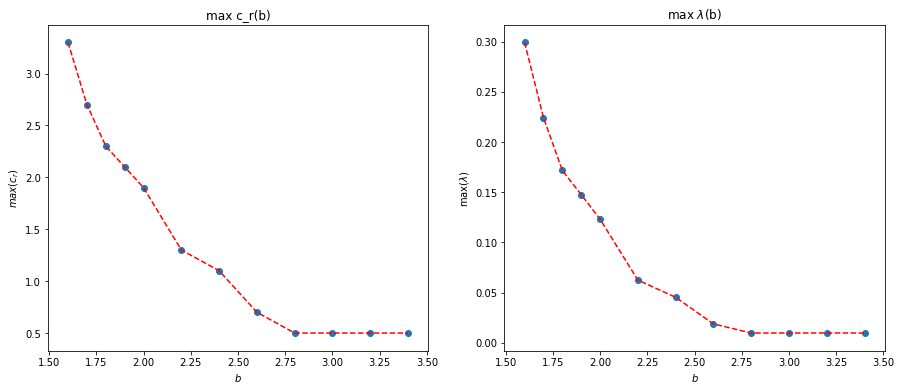

In [12]:
plt.figure(1, figsize=(15,6))
plt.subplot(121)
plt.plot(bs, best_c, 'r--')
plt.scatter(bs, best_c)
plt.ylabel('$max(c_r)$')
plt.xlabel('$b$')    
plt.title('max c_r(b)')

plt.subplot(122)
plt.plot(bs, best_l, 'r--')
plt.scatter(bs, best_l)
plt.ylabel('$\max (\lambda)$')
plt.xlabel('$b$')    
plt.title('max $\lambda$(b)')
plt.show()

In [13]:
lmbd_max = {}
for ind,b in enumerate(bs):
    lmbd_max[b] = indx[ind]

In [14]:
lmbd_max

{1.6: 4,
 1.7: 6,
 1.8: 9,
 1.9: 9,
 2.0: 11,
 2.2: 14,
 2.4: 15,
 2.6: 17,
 2.8: 18,
 3.0: 18,
 3.2: 18,
 3.4: 18}

# Параметры $\lambda$ и  $\gamma$

Посчитаем параметры
$$
\lambda_1 = \frac{\sum E_r}{\sum H}
$$

$$
\gamma = \frac{\frac{m_r}{2} (c_r^2 - {c'}_r^2)}{H_r} = \frac{T_r - T_r'}{H_r} = \lambda_{init} - \lambda_{end} 
$$

от $\lambda_{init}$ при ограничении  $\lambda_{init}$ до max($\lambda_{init}$) для каждого $b$, при которых $\lambda_{end}$ не меняется.

Так же посчитаем:
    1. Наклон прямой, приближающей $\gamma$;
    2. Наклон прямой, приближающей $\lambda$;
    3. Точку персечения прямой (1) с 0;
    3. Точку персечения прямой (2) с биссектрисой;

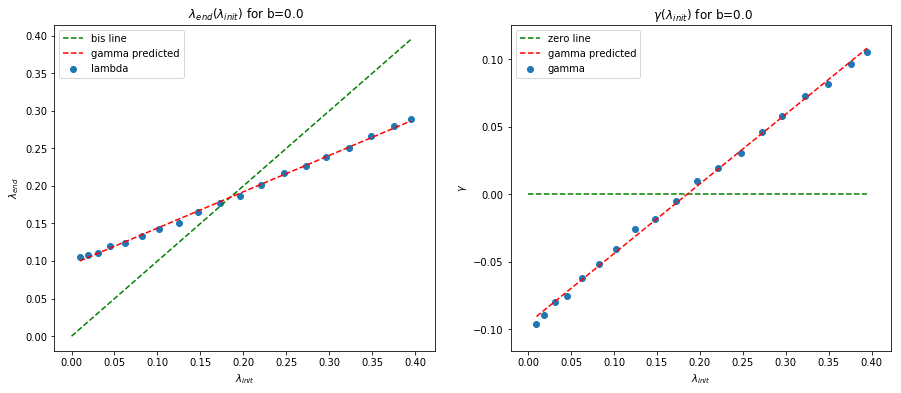

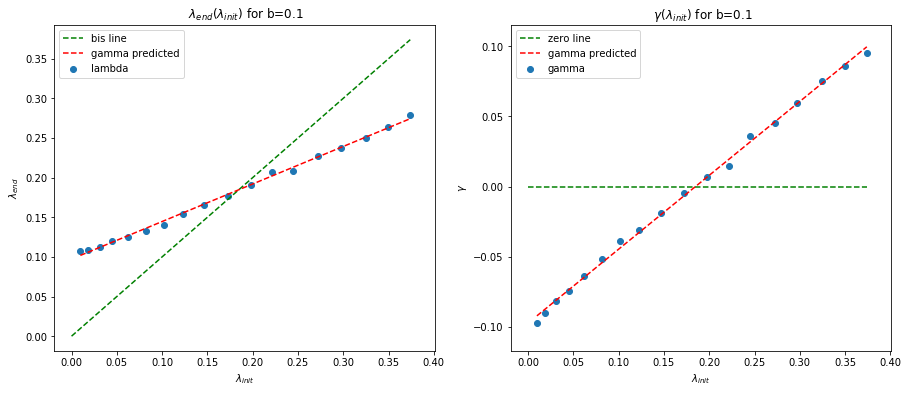

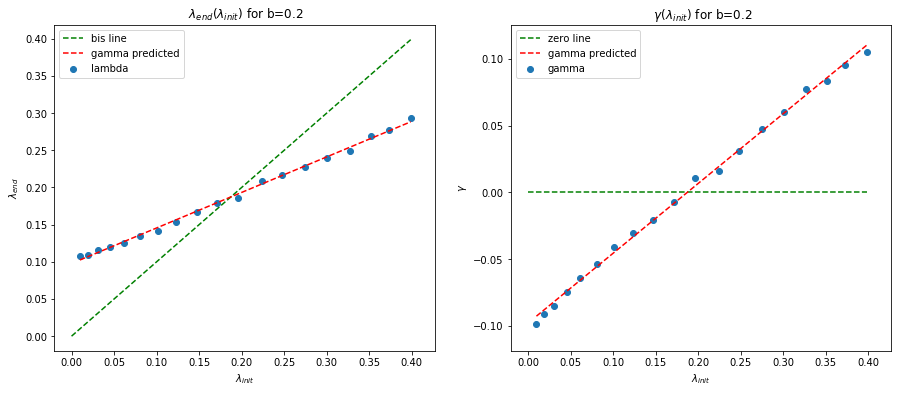

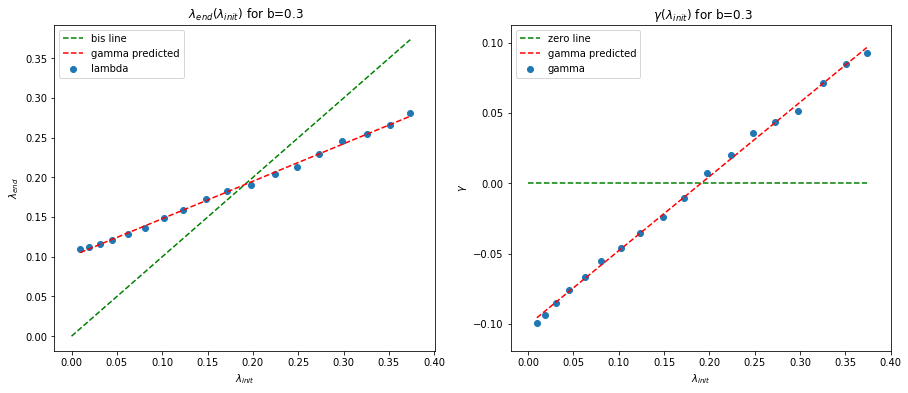

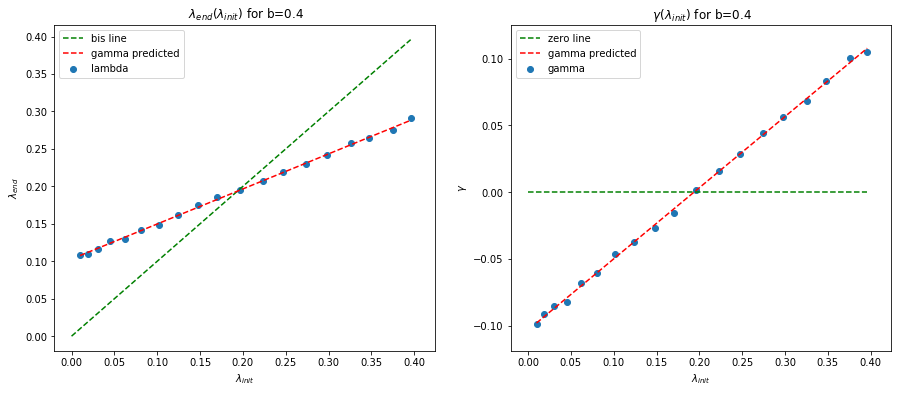

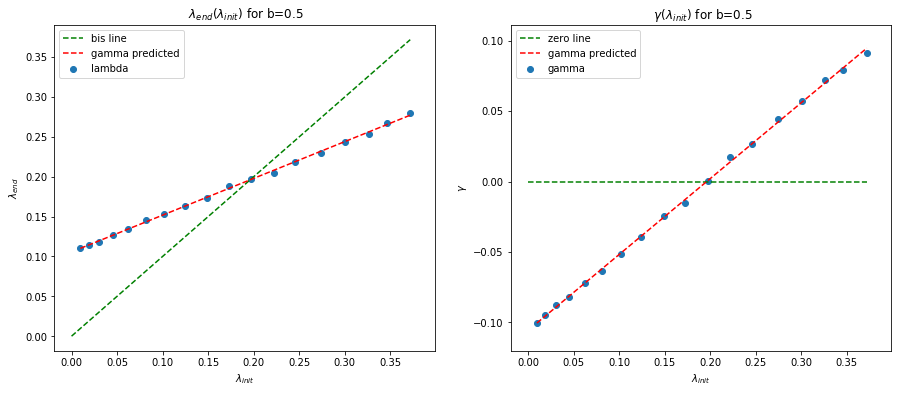

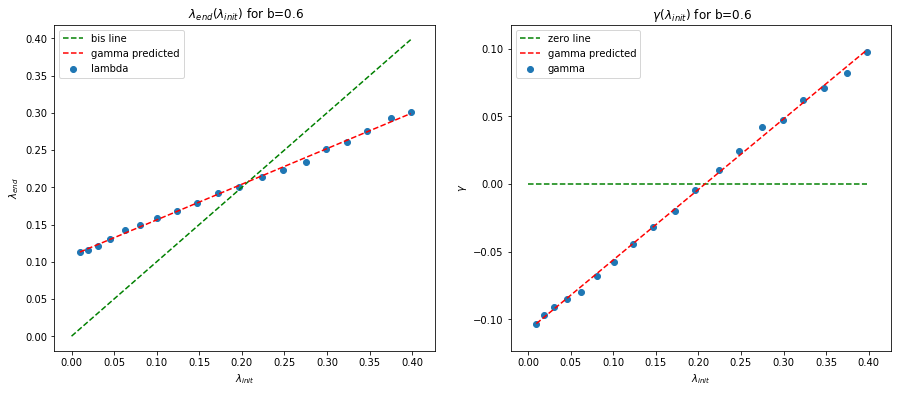

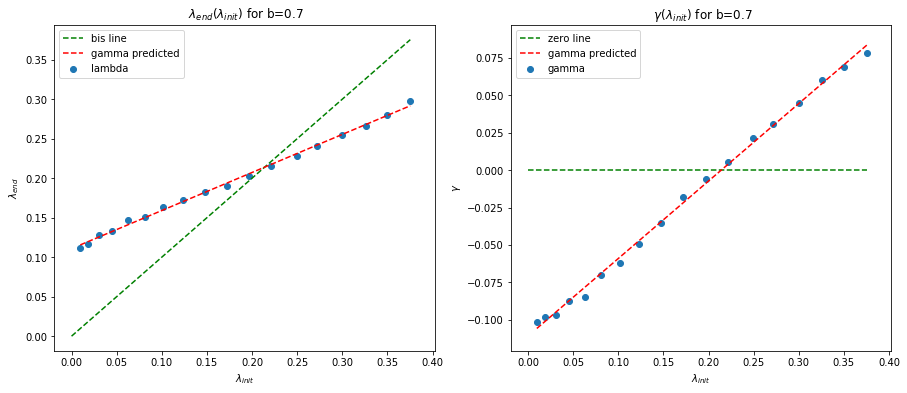

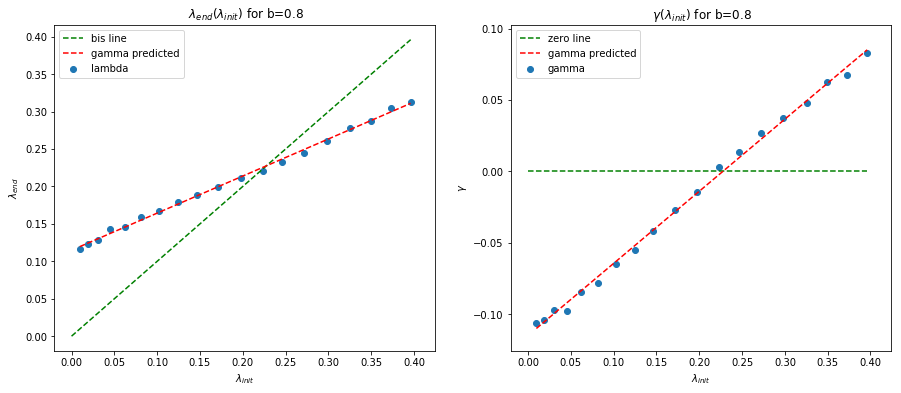

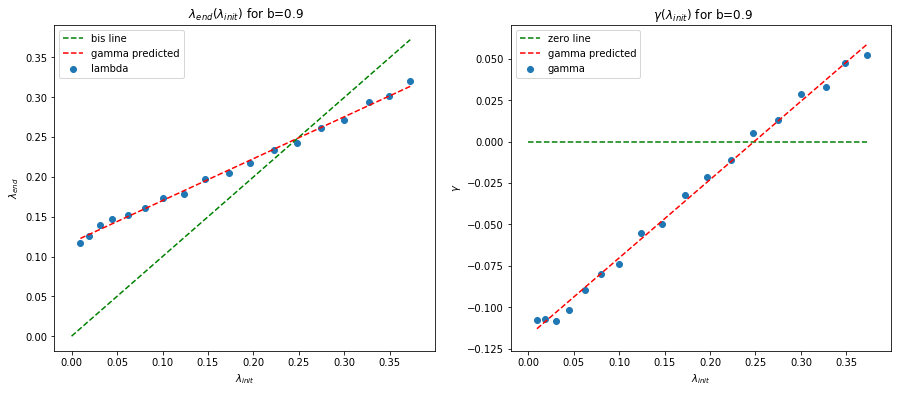

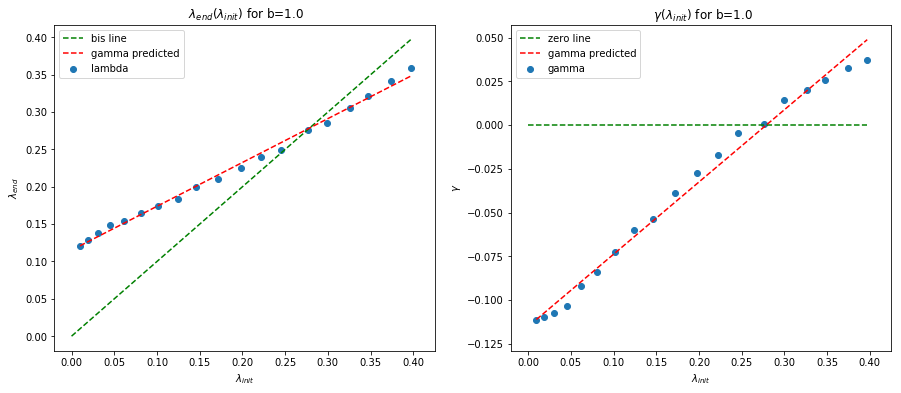

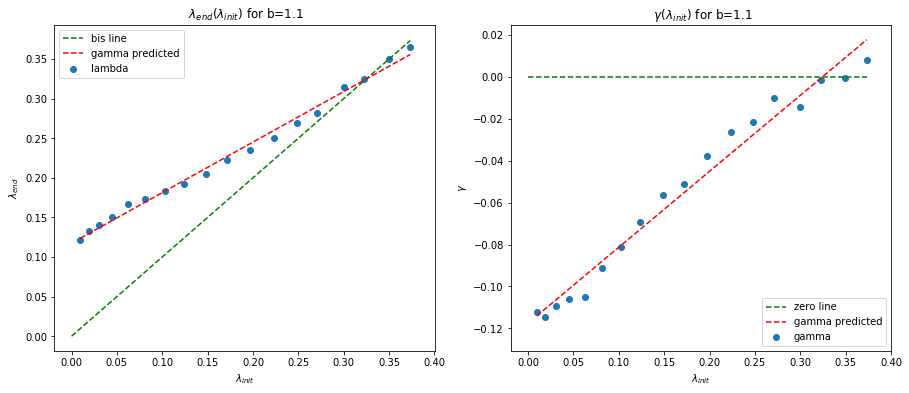

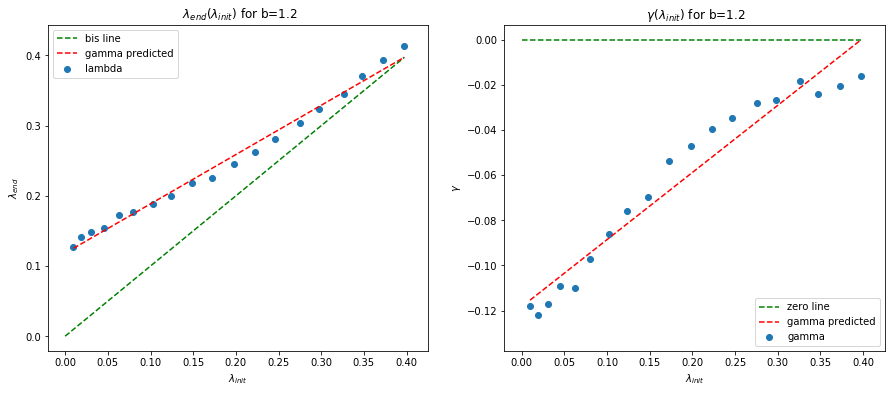

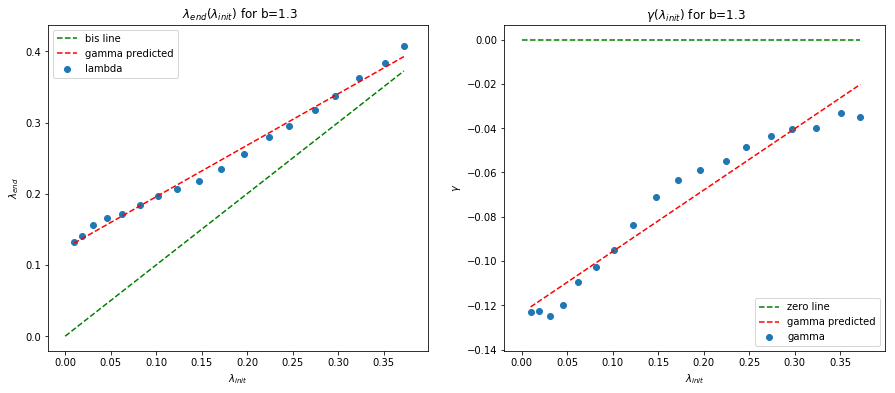

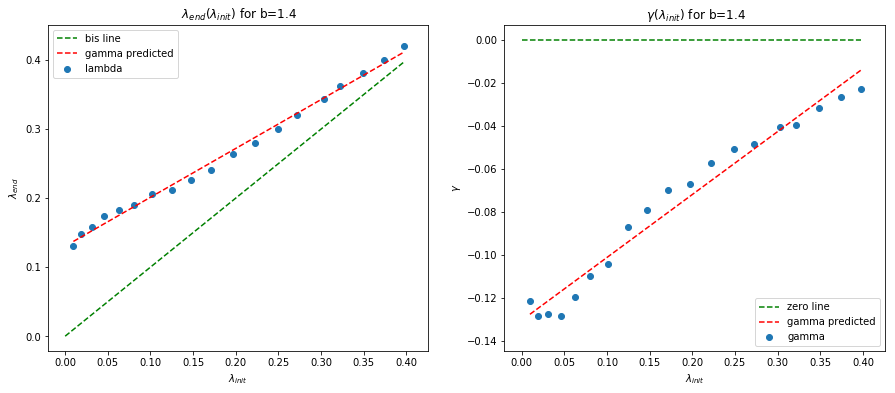

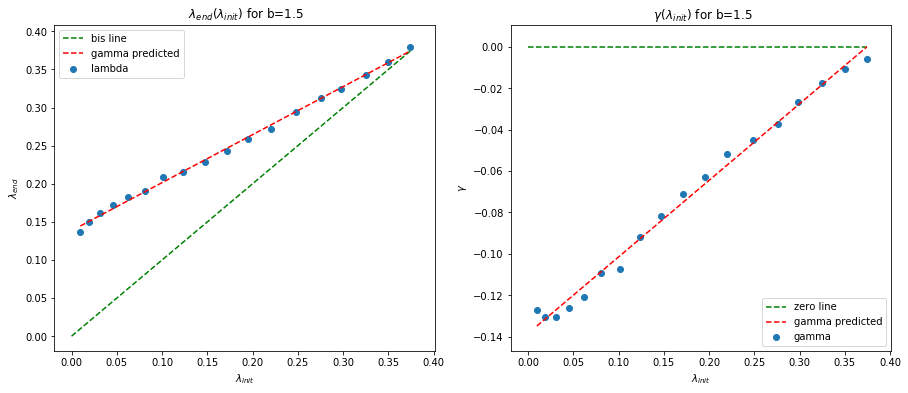

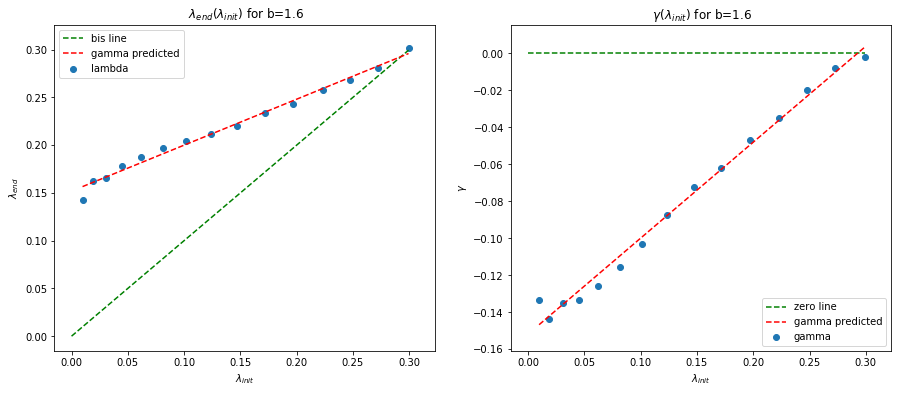

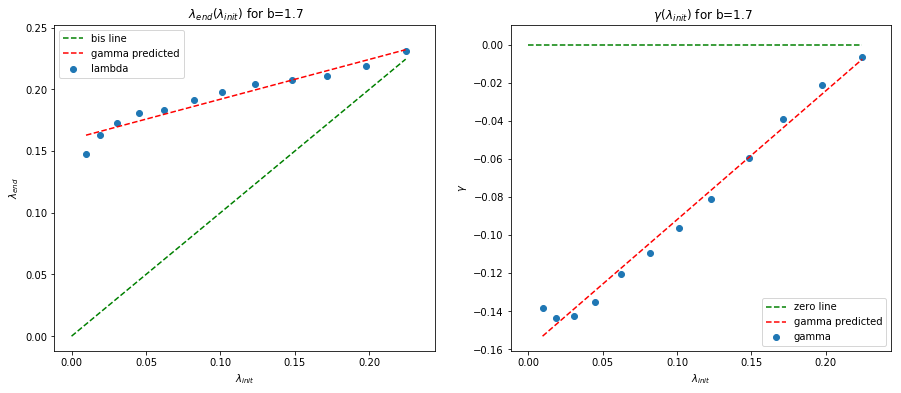

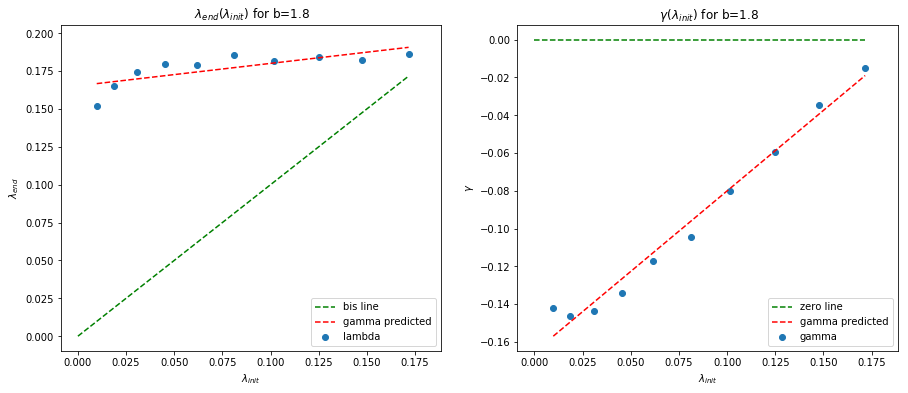

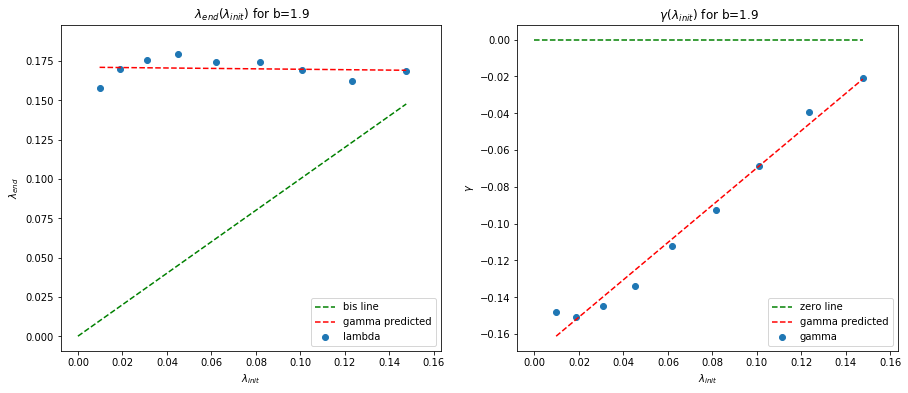

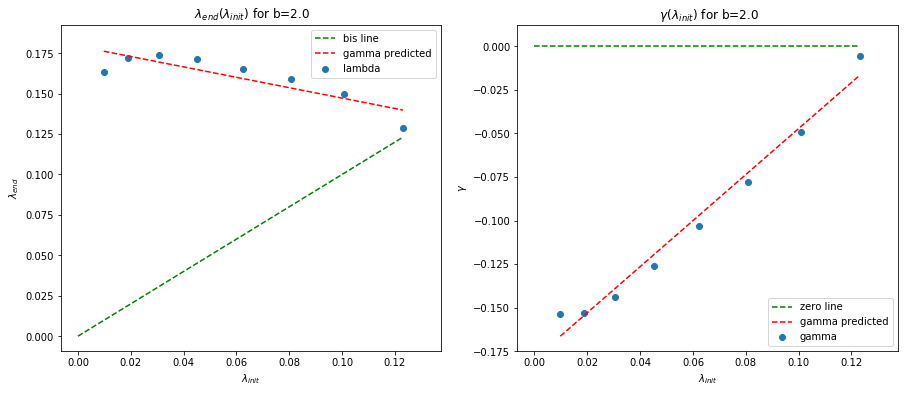

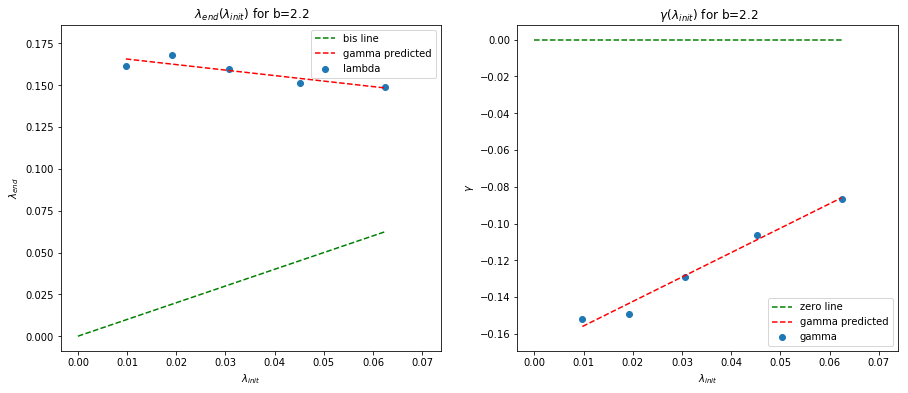

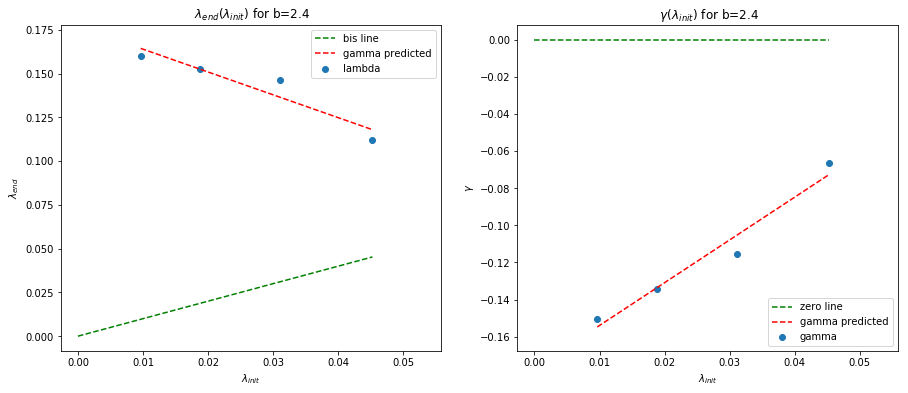

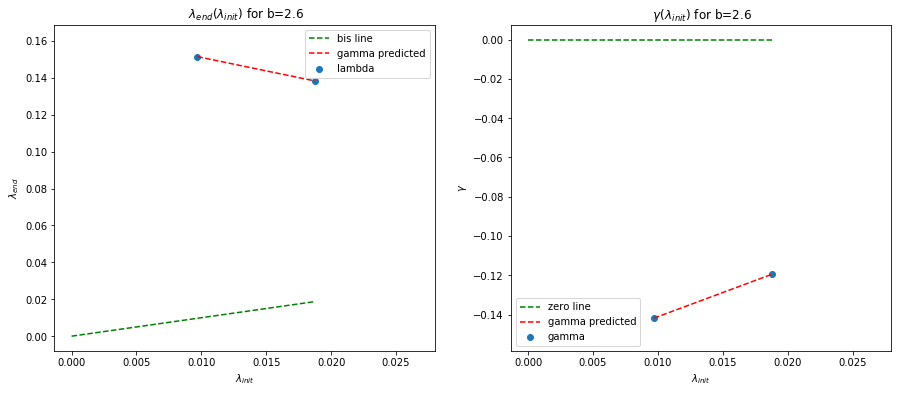

In [111]:
incline_lmbd = []
incline_gamma = []
intersection_lmbd = []
intersection_gamma = []
t_gamma = []
arr_b = []

for b in sorted(result_b.keys()):
    
    if float(b) in lmbd_max:
        x = (result_b[b]["l1"])[:-lmbd_max[float(b)]]
        arr = (result_b[b]["l1"] - result_b[b]["l2"])[:-lmbd_max[float(b)]]
        arr_lambda = (result_b[b]["l2"])[:-lmbd_max[float(b)]]
    else:
        x = result_b[b]["l1"]
        arr = result_b[b]["l1"] - result_b[b]["l2"]
        arr_lambda = (result_b[b]["l2"])
        
    if (len(x) > 1):
        
        arr_b.append(float(b))
        
        plt.figure(1, figsize=(15,6))
        
        plt.subplot(121)
        plt.scatter(x,arr_lambda, label = "lambda")
        plt.plot([0. ,np.max(x)], [0. ,np.max(x)], "g--",label = "bis line")
        fit = np.polyfit(x,arr_lambda,1)
        fit_fn = np.poly1d(fit) 
        plt.plot(x, fit_fn(x), 'r--', label = "gamma predicted")

        plt.xlabel('$\lambda_{init}$')
        plt.ylabel('$\lambda_{end}$')    
        plt.title(' $\lambda_{end}(\lambda_{init})$ for b=%s'%(b))
        plt.legend()
        
        #параметры
        incline_lmbd.append(fit[0])
        intersection_lmbd.append(fit[1]/(1 - fit[0]))
        t_gamma.append(fit[1])
        plt.subplot(122)
        plt.scatter(x,arr, label = "gamma")
        plt.plot([0. ,np.max(x)], [0. ,0], "g--", label = "zero line")

        fit = np.polyfit(x,arr,1)
        fit_fn = np.poly1d(fit) 
        plt.plot(x, fit_fn(x), 'r--', label = "gamma predicted")
        plt.xlabel('$\lambda_{init}$')
        plt.ylabel('$\gamma$')    
        plt.title(' $\gamma(\lambda_{init})$ for b=%s'%(b))
        plt.legend()
        
        #параметры
        incline_gamma.append(fit[0])
        intersection_gamma.append(- fit[1]/fit[0])

        plt.show()



### Распределение tg угла наклона и точки пересечения с биссектрисой для $\lambda$ от $b$

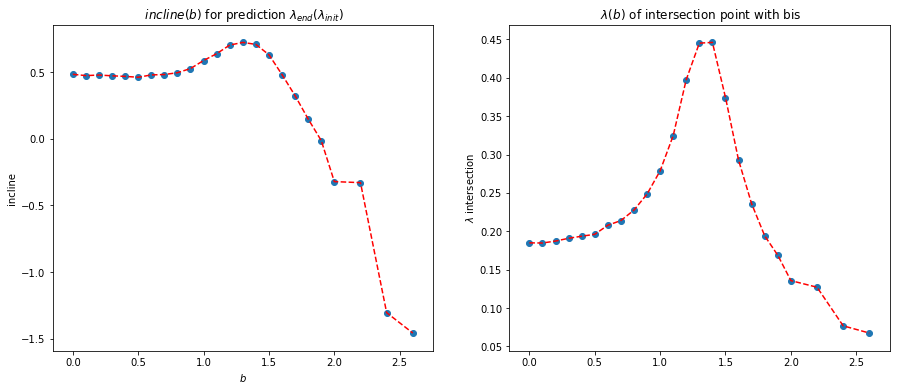

In [56]:
plt.figure(1, figsize=(15,6))

plt.subplot(121)
plt.plot(arr_b, incline_lmbd, 'r--')
plt.scatter(arr_b, incline_lmbd)

plt.xlabel('$b$')

plt.xlabel('$b$')
plt.ylabel('incline')    
plt.title(' $incline(b)$ for prediction $\lambda_{end}(\lambda_{init})$')


plt.subplot(122)
plt.plot(arr_b, intersection_lmbd, 'r--')
plt.scatter(arr_b, intersection_lmbd)

plt.xlabel('$b$')
plt.ylabel('$\lambda$ intersection')    
plt.title(' $\lambda(b)$ of intersection point with bis')


plt.show()

### Распределение tg угла наклона и точки пересечения с биссектрисой для $\gamma$ от $b$

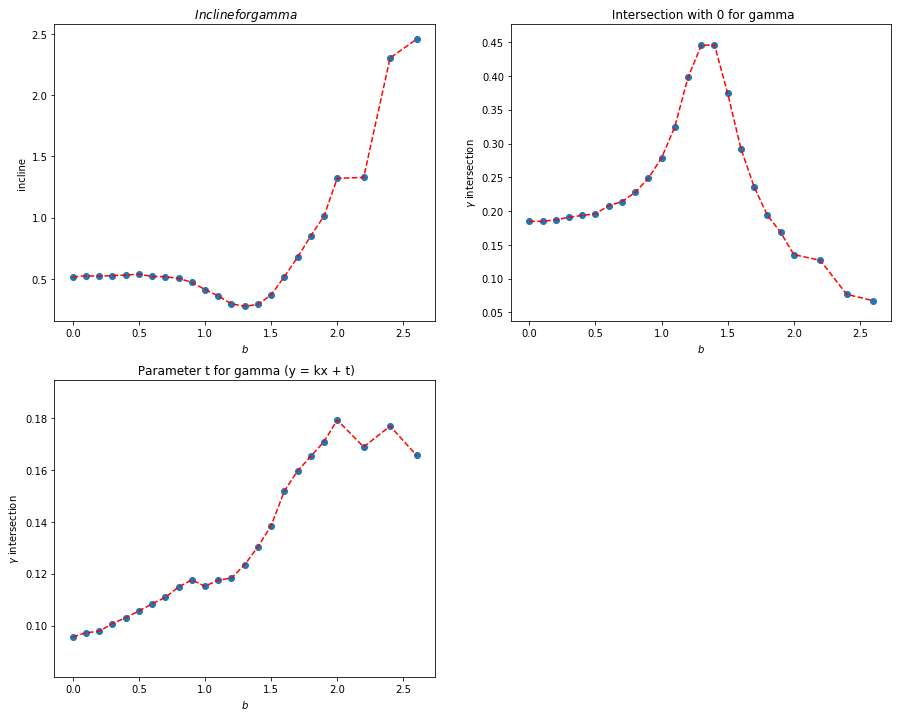

In [117]:
plt.figure(1, figsize=(15,12))

plt.subplot(221)
plt.scatter(arr_b, incline_gamma)
plt.plot(arr_b, incline_gamma, 'r--')
plt.xlabel('$b$')
plt.ylabel('incline')    
plt.title(' $Incline for gamma$')
plt.subplot(222)
plt.scatter(arr_b, intersection_gamma)
plt.plot(arr_b, intersection_gamma, 'r--')
plt.xlabel('$b$')
plt.ylabel('$\gamma$ intersection')    
plt.title(' Intersection with 0 for gamma')

plt.subplot(223)
plt.scatter(arr_b, t_gamma)
plt.plot(arr_b, t_gamma, 'r--')
plt.xlabel('$b$')
plt.ylabel('$\gamma$ intersection')    
plt.title(' Parameter t for gamma (y = kx + t)')

plt.show()

### Выводы:
    1. Для обоих параметров прослеживается квадратичная (или экспоненциаьная) зависимость.
    2. Точка пересечения с 0 более гладкая, чем параметр t --- будем прбилижать её.

### Посмотрим подробнее участок от 0 до 1.5 $b$

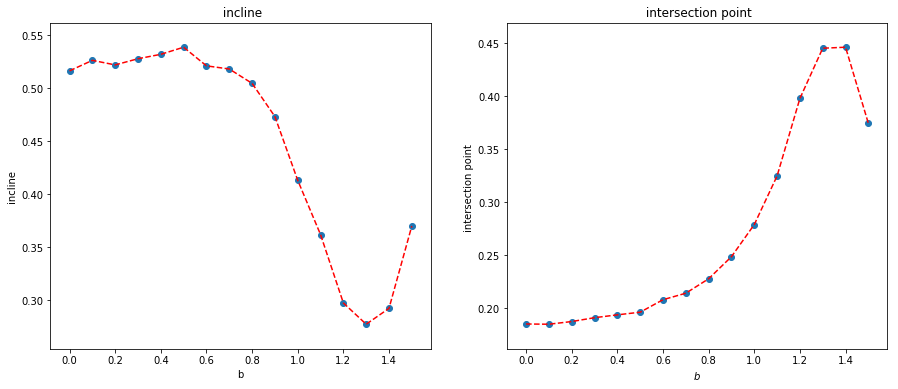

In [137]:
for ind, el in enumerate(arr_b):
    if el > 1.5:
        break

plt.figure(1, figsize=(15,6))

plt.subplot(121)
plt.scatter(arr_b[:ind], incline_gamma[:ind])
plt.plot(arr_b[:ind], incline_gamma[:ind], 'r--')
plt.xlabel('b')
plt.ylabel('incline')    
plt.title(' incline')

plt.subplot(122)
plt.scatter(arr_b[:ind], intersection_gamma[:ind])
plt.plot(arr_b[:ind], intersection_gamma[:ind], 'r--')
plt.xlabel('$b$')
plt.ylabel('intersection point ')    
plt.title(' intersection point')

plt.show()

In [138]:
print "Минимальная точка перемечения для $\gamma$: ", np.min(intersection_gamma[:ind])
print "Максимальная точка перемечения для $\gamma$: ", np.max(intersection_gamma[:ind])
print "Минимальный tg наклона для предсказанной $\gamma$ от b: ", np.min( incline_gamma[:ind])
print "Максимальный tg наклона для предсказанной $\gamma$ от b: ", np.max(incline_gamma[:ind])

Минимальная точка перемечения для $\gamma$:  0.18471094268351004
Максимальная точка перемечения для $\gamma$:  0.44610065743699756
Минимальный tg наклона для предсказанной $\gamma$ от b:  0.27738492579330937
Максимальный tg наклона для предсказанной $\gamma$ от b:  0.5388378375495977


# Предскажим параметры

найдём границу по b, будем рассматривать кусочный график.

In [139]:
border = np.argmin(incline_gamma) + 1
arr_b[border]

1.4

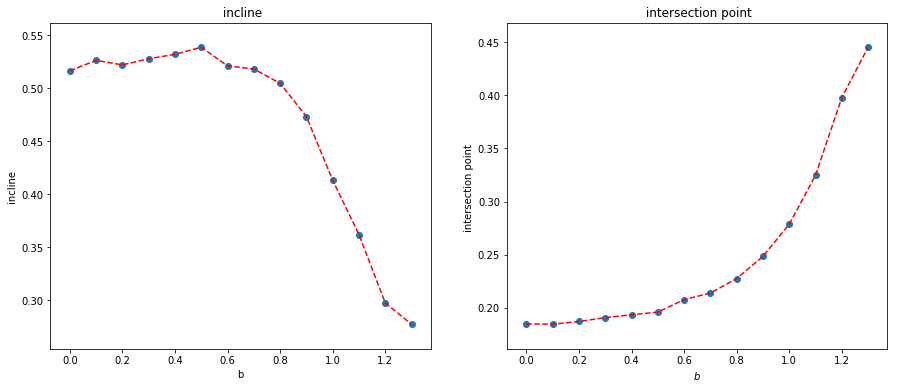

In [140]:

plt.figure(1, figsize=(15,6))

plt.subplot(121)
plt.scatter(arr_b[:border], incline_gamma[:border])
plt.plot(arr_b[:border], incline_gamma[:border], 'r--')
plt.xlabel('b')
plt.ylabel('incline')    
plt.title(' incline')

plt.subplot(122)
plt.scatter(arr_b[:border], intersection_gamma[:border])
plt.plot(arr_b[:border], intersection_gamma[:border], 'r--')
plt.xlabel('$b$')
plt.ylabel('intersection point ')    
plt.title(' intersection point')
plt.show()

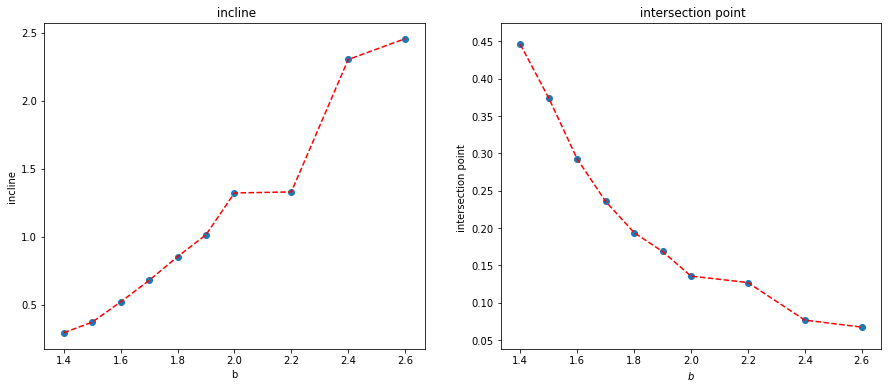

In [141]:

plt.figure(1, figsize=(15,6))

plt.subplot(121)
plt.scatter(arr_b[border:], incline_gamma[border:])
plt.plot(arr_b[border:], incline_gamma[border:], 'r--')
plt.xlabel('b')
plt.ylabel('incline')    
plt.title(' incline')

plt.subplot(122)
plt.scatter(arr_b[border:], intersection_gamma[border:])
plt.plot(arr_b[border:], intersection_gamma[border:], 'r--')
plt.xlabel('$b$')
plt.ylabel('intersection point ')    
plt.title(' intersection point')

plt.show()

## Рассмотрим первую часть

Рассмотрим параметры функции y=kx+t для приближения коэффициента gamma при b < 1.4.

Предположим, что оба параметра k и t можно приблизить степенными законом.

Рассмотрим степени с 1 до 10.

_______________________________________________________
Degree:  0
Параметры для tg угла наклона: [0.46655387]
ERROR  для tg угла наклона :  0.10778948382256254
Параметры для пересечения с 0: [0.24868183]
ERROR для пересечения с 0:  0.09188342126819228


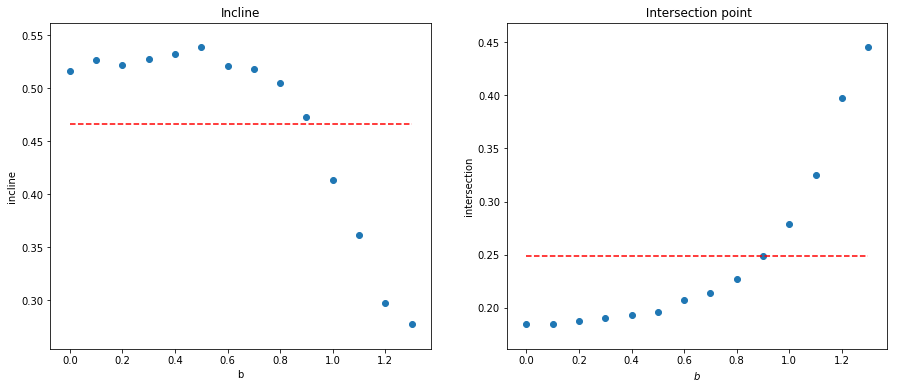

_______________________________________________________
Degree:  1
Параметры для tg угла наклона: [-0.1817787   0.58471003]
ERROR  для tg угла наклона :  0.032615531719850904
Параметры для пересечения с 0: [0.17478419 0.1350721 ]
ERROR для пересечения с 0:  0.022383279853528774


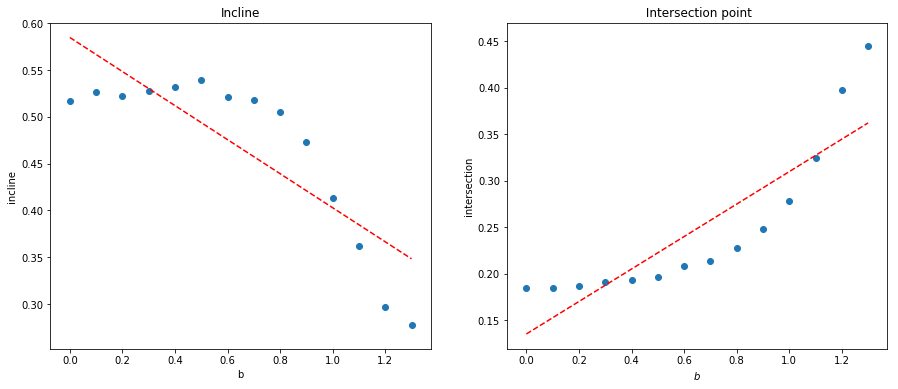

_______________________________________________________
Degree:  2
Параметры для tg угла наклона: [-0.32105589  0.23559396  0.5012355 ]
ERROR  для tg угла наклона :  0.002599543134625607
Параметры для пересечения с 0: [ 0.26116261 -0.16472721  0.20297438]
ERROR для пересечения с 0:  0.002521718925957702


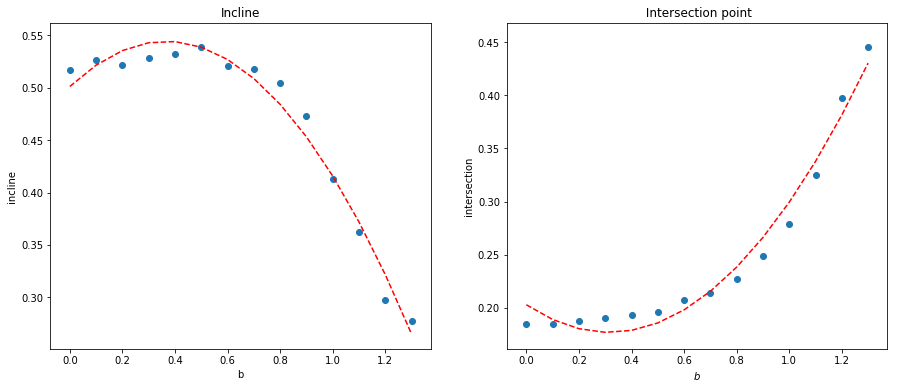

_______________________________________________________
Degree:  3
Параметры для tg угла наклона: [-0.11940985 -0.08820667  0.11893053  0.51148086]
ERROR  для tg угла наклона :  0.002100396912230273
Параметры для пересечения с 0: [ 0.24682058 -0.22013753  0.0764165   0.18179718]
ERROR для пересечения с 0:  0.0003891150155621792


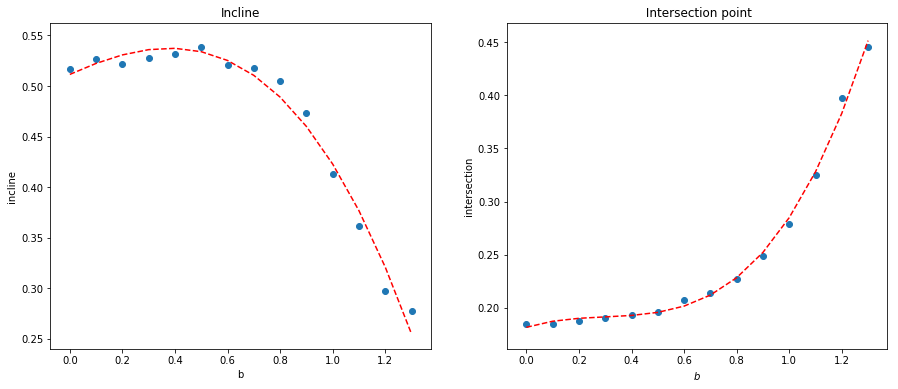

_______________________________________________________
Degree:  4
Параметры для tg угла наклона: [ 0.50285244 -1.42682621  0.97999559 -0.16496559  0.52380793]
ERROR  для tg угла наклона :  0.0010887696454021313
Параметры для пересечения с 0: [ 0.04195475  0.13773822 -0.13101364  0.05273005  0.18282567]
ERROR для пересечения с 0:  0.0003820729224270007


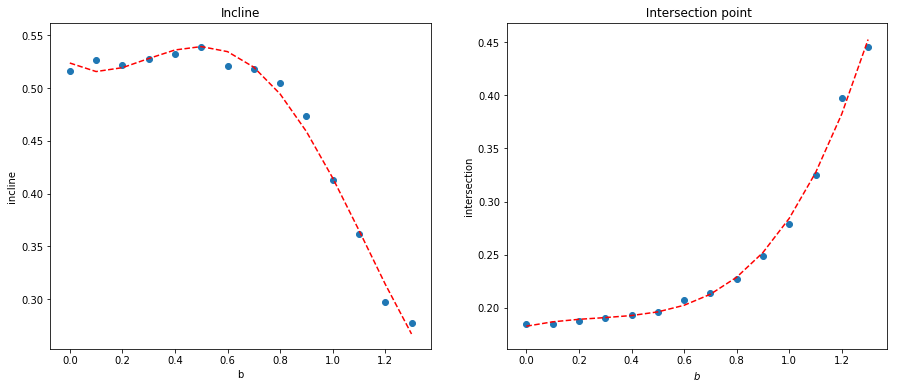

_______________________________________________________
Degree:  5
Параметры для tg угла наклона: [ 1.3153742  -3.77211369  3.44005832 -1.28573646  0.20311369  0.51574657]
ERROR  для tg угла наклона :  0.0003414972036739654
Параметры для пересечения с 0: [-0.56929057  1.8921491  -1.96863688  0.84958936 -0.10657372  0.18631461]
ERROR для пересечения с 0:  0.0002420986208684053


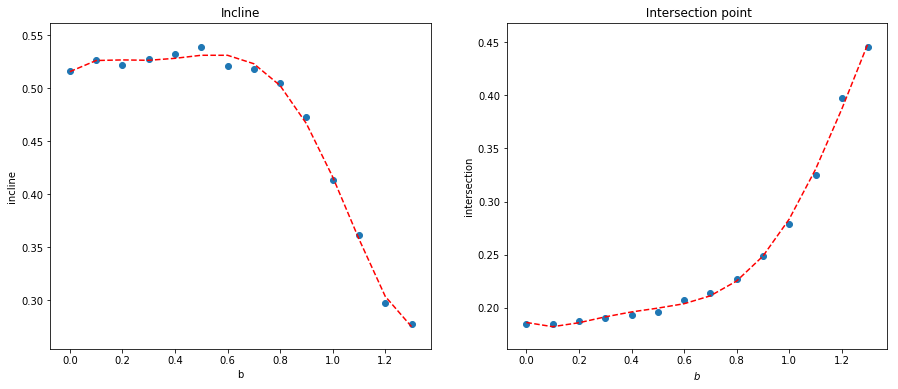

_______________________________________________________
Degree:  6
Параметры для tg угла наклона: [ 1.43089409 -4.26511274  4.39048666 -2.06433107  0.38859173  0.02129128
  0.51765988]
ERROR  для tg угла наклона :  0.0002524496972410292
Параметры для пересечения с 0: [-1.70180254  6.06773932 -7.81586082  4.57788805 -1.1417362   0.10967278
  0.18403905]
ERROR для пересечения с 0:  0.00011614080577789276


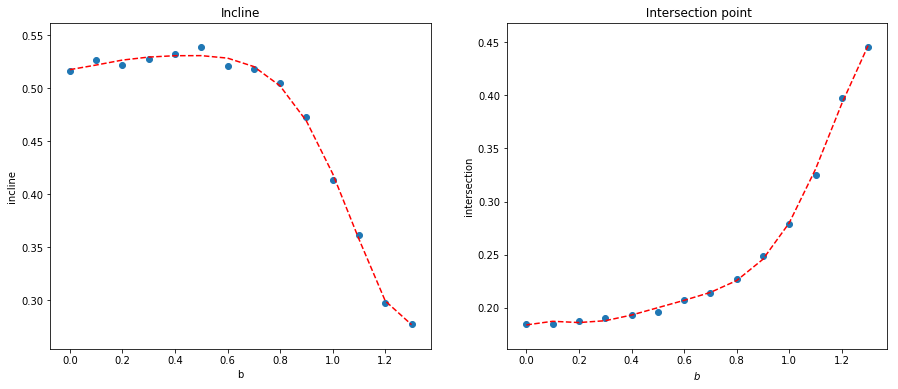

_______________________________________________________
Degree:  7
Параметры для tg угла наклона: [  2.19731186  -8.56687489  13.61847047 -11.49058483   5.18234123
  -1.18072241   0.14379913   0.51710615]
ERROR  для tg угла наклона :  0.00023305830467227622
Параметры для пересечения с 0: [ -4.38886626  18.26753893 -29.65256793  23.90467005  -9.89646856
   1.99278011  -0.13502192   0.18514505]
ERROR для пересечения с 0:  3.877834221925868e-05


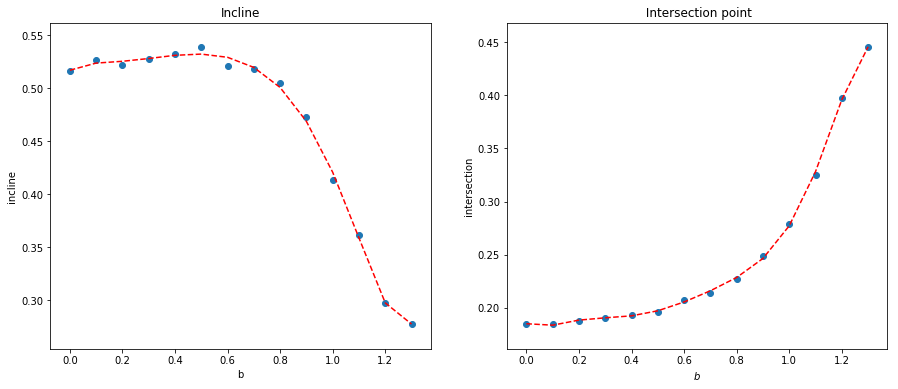

_______________________________________________________
Degree:  8
Параметры для tg угла наклона: [ -12.36302673   66.48505085 -144.60962101  163.92320422 -103.83069717
   36.12254644   -6.273362      0.44987602    0.51660768]
ERROR  для tg угла наклона :  0.000182215564652
Параметры для пересечения с 0: [-6.32926480e+00  2.85233107e+01 -5.13796909e+01  4.72961018e+01
 -2.33689495e+01  5.94340269e+00 -6.14402190e-01  2.16744755e-02
  1.84889852e-01]
ERROR для пересечения с 0:  2.5452770145810355e-05


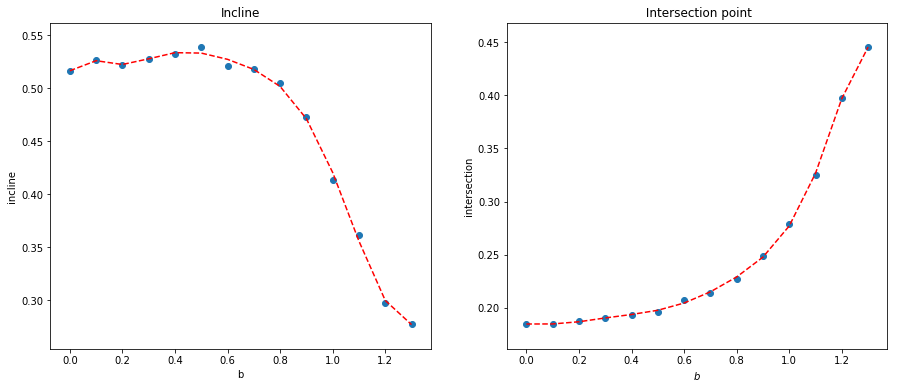

_______________________________________________________
Degree:  9
Параметры для tg угла наклона: [ 3.55013402e+01 -2.20045867e+02  5.74195982e+02 -8.16769025e+02
  6.85700811e+02 -3.43781342e+02  9.87998548e+01 -1.45578249e+01
  8.58672302e-01  5.16418224e-01]
ERROR  для tg угла наклона :  0.00015198897337212518
Параметры для пересечения с 0: [-1.80123790e+01  9.90431524e+01 -2.29074900e+02  2.89655038e+02
 -2.17439143e+02  9.83752421e+01 -2.58572963e+01  3.58890067e+00
 -1.85737231e-01  1.84985974e-01]
ERROR для пересечения с 0:  1.767165521745866e-05


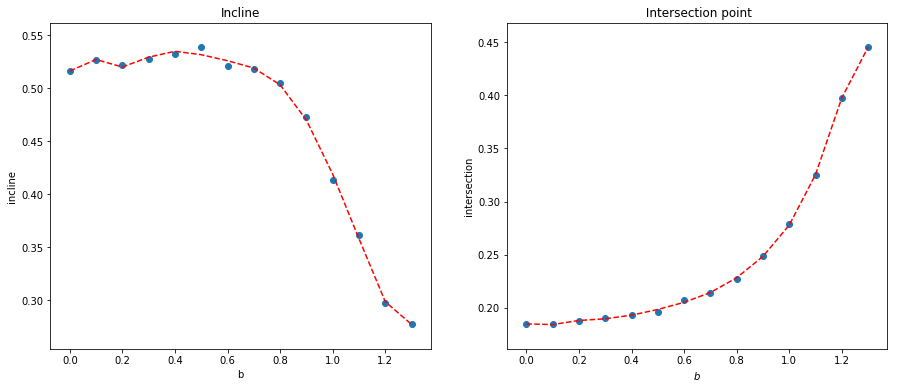

In [142]:
ERR_incl = []
ERR_intersect = []
for degree in xrange(10):
    print "_______________________________________________________"
    print "Degree: ", degree
    
    intersection_gamma= np.array(intersection_gamma)
    incline_gamma= np.array(incline_gamma)
    plt.figure(1, figsize=(15,6))

    plt.subplot(121)
    plt.scatter(arr_b[:border], incline_gamma[:border], label = "real")
    
    # предсказываем
    fit = np.polyfit(arr_b[:border],incline_gamma[:border],degree)
    fit_fn = np.poly1d(fit) 
    plt.plot(arr_b[:border], fit_fn(arr_b[:border]), 'r--', label = "predicted")
    print "Параметры для tg угла наклона:", fit
    print "ERROR  для tg угла наклона : ", np.sum((fit_fn(arr_b[:border]) - incline_gamma[:border])**2) 
    ERR_incl.append(np.sum((fit_fn(arr_b[:border]) - incline_gamma[:border])**2) )
    #plt.plot(arr_b[:border], np.log(2 * incline_gamma[:border]), 'r--')
    plt.xlabel('b')
    plt.ylabel('incline')    
    plt.title('Incline')


    plt.subplot(122)
    plt.scatter(arr_b[:border], intersection_gamma[:border], label = "real")
    # предсказываем
    fit = np.polyfit(arr_b[:border],intersection_gamma[:border],degree)
    fit_fn = np.poly1d(fit) 
    plt.plot(arr_b[:border], fit_fn(arr_b[:border]), 'r--', label = "predicted")
    print "Параметры для пересечения с 0:", fit
    print "ERROR для пересечения с 0: ", np.sum((fit_fn(arr_b[:border]) - intersection_gamma[:border])**2) 
    ERR_intersect.append(np.sum((fit_fn(arr_b[:border]) - intersection_gamma[:border])**2) )
    #plt.plot(arr_b[:border], np.log(5 * intersection_gamma[:border]), 'r--')


    
    plt.xlabel('$b$')
    plt.ylabel('intersection')    
    plt.title(' Intersection point')
    plt.show()

### Графики ошиок

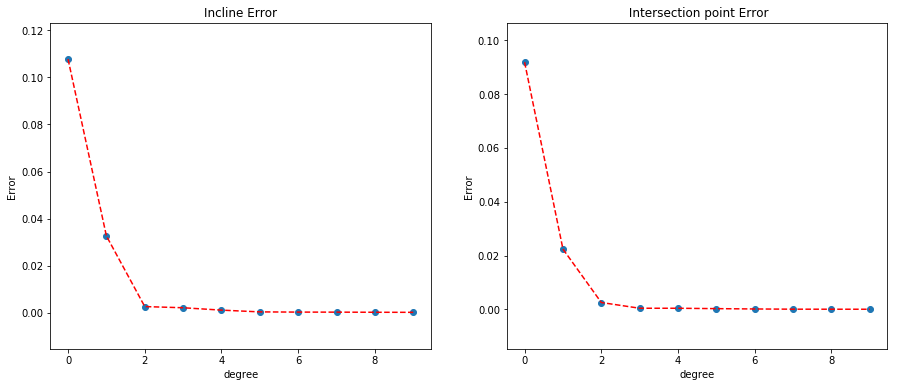

In [135]:
plt.figure(1, figsize=(15,6))

plt.subplot(121)
plt.scatter(range(10), ERR_incl, label = "real")
plt.plot(range(10), ERR_incl, 'r--', label = "predicted")

plt.xlabel('degree')
plt.ylabel('Error')    
plt.title('Incline Error')


plt.subplot(122)
plt.scatter(range(10), ERR_intersect, label = "real")
plt.plot(range(10), ERR_intersect, 'r--', label = "predicted")


plt.xlabel('degree')
plt.ylabel('Error')    
plt.title(' Intersection point Error')

plt.show()

#### Посмотрим ошибки без первых 2х степеней (линейные)

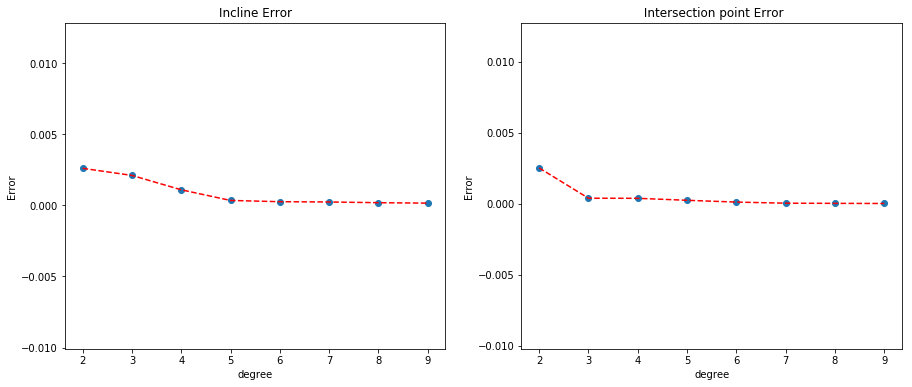

In [136]:

plt.figure(1, figsize=(15,6))

plt.subplot(121)
plt.scatter(range(2,10), ERR_incl[2:], label = "real")
plt.plot(range(2,10), ERR_incl[2:], 'r--', label = "predicted")

plt.xlabel('degree')
plt.ylabel('Error')    
plt.title('Incline Error')

plt.subplot(122)
plt.scatter(range(2,10), ERR_intersect[2:], label = "real")
plt.plot(range(2,10), ERR_intersect[2:], 'r--', label = "predicted")

plt.xlabel('degree')
plt.ylabel('Error')    
plt.title(' Intersection point Error')
plt.show()

### Выводы:
    1. Заметно, что качественное улучшение наклона имеется при степенях 2 и 5;
    2. Качественное улучшение предсказания точки пересечения имеется при степени 3.

## Рассмотрим вторую часть

Рассмотрим параметры функции y=kx+t для приближения коэффициента gamma при b > 1.4.

Предположим, что оба параметра k и t можно приблизить степенными законом.

Рассмотрим степени с 1 до 10.

_______________________________________________________
Degree:  0
Параметры для tg угла наклона: [1.11358864]
ERROR  для tg угла наклона :  5.161325338150371
Параметры для пересечения с 0: [0.21185702]
ERROR для пересечения с 0:  0.14259907623455417


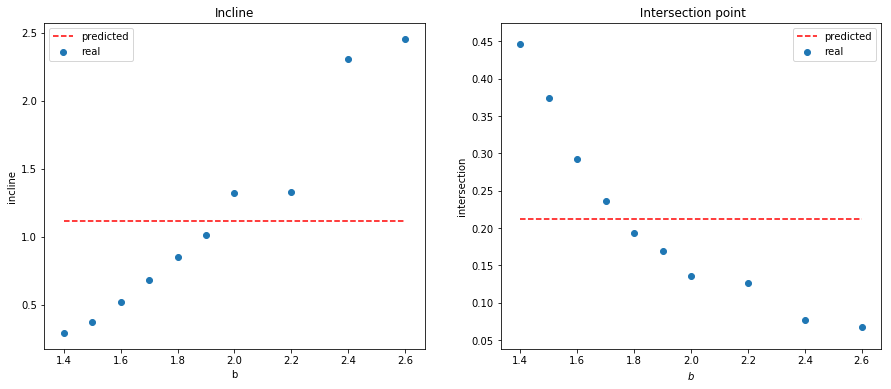

_______________________________________________________
Degree:  1
Параметры для tg угла наклона: [ 1.8869048  -2.49039953]
ERROR  для tg угла наклона :  0.21591621629623534
Параметры для пересечения с 0: [-0.29587846  0.77698488]
ERROR для пересечения с 0:  0.021000370037495022


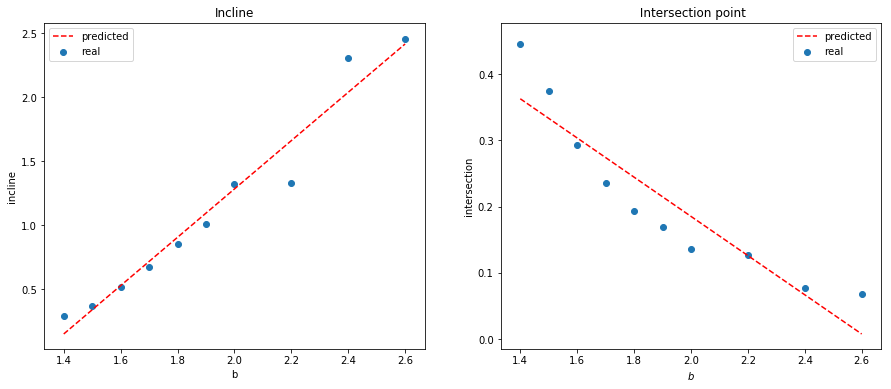

_______________________________________________________
Degree:  2
Параметры для tg угла наклона: [ 0.56231047 -0.35395705 -0.33982312]
ERROR  для tg угла наклона :  0.16282692353710343
Параметры для пересечения с 0: [ 0.33200997 -1.61897045  2.04676884]
ERROR для пересечения с 0:  0.002492482517670591


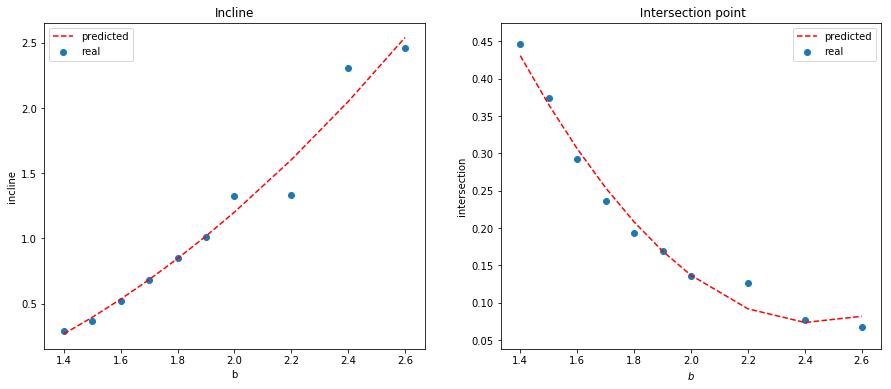

_______________________________________________________
Degree:  3
Параметры для tg угла наклона: [-0.33169312  2.54125403 -4.20109846  2.09675251]
ERROR  для tg угла наклона :  0.16099932427542213
Параметры для пересечения с 0: [-0.33284185  2.31780708 -5.47943542  4.4917829 ]
ERROR для пересечения с 0:  0.0006522025194082412


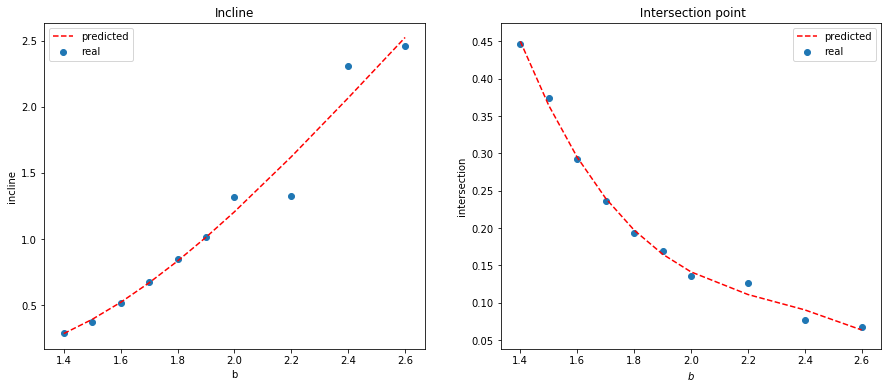

_______________________________________________________
Degree:  4
Параметры для tg угла наклона: [ -2.24904734  17.61856746 -50.36069163  63.99801736 -30.34389689]
ERROR  для tg угла наклона :  0.15304619331372557
Параметры для пересечения с 0: [ 0.10630489 -1.1812902   4.81830383 -8.70297786  6.0251431 ]
ERROR для пересечения с 0:  0.0006344341559103467


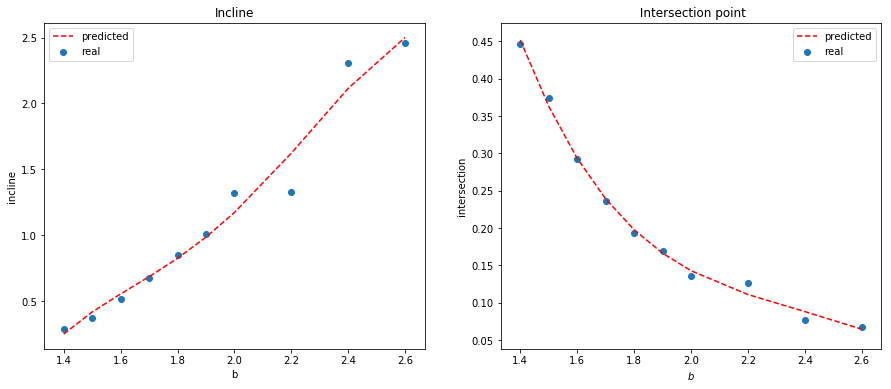

_______________________________________________________
Degree:  5
Параметры для tg угла наклона: [  -24.51832883   241.23906292  -938.28917647  1803.63985829
 -1712.22704898   642.09303999]
ERROR  для tg угла наклона :  0.08454763993168016
Параметры для пересечения с 0: [   1.88244693  -18.58801348   72.21056324 -137.52653801  127.67048554
  -45.60263524]
ERROR для пересечения с 0:  0.00023065383308614872


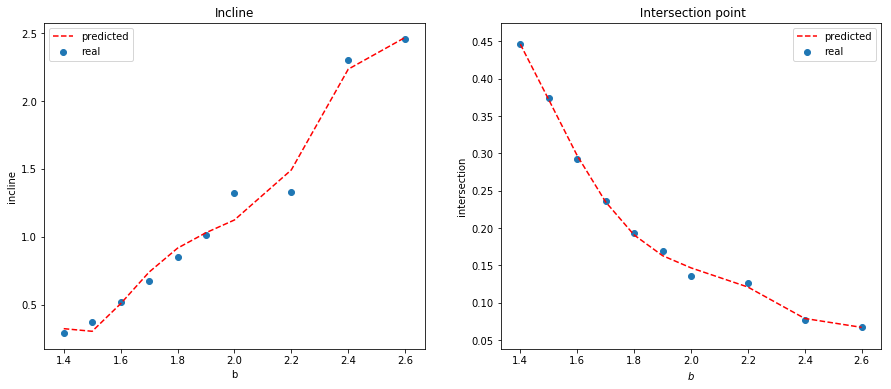

_______________________________________________________
Degree:  6
Параметры для tg угла наклона: [   -87.46984162   1014.58335766  -4855.37412135  12270.76709893
 -17272.95956076  12842.76802919  -3941.23924561]
ERROR  для tg угла наклона :  0.029547453493691596
Параметры для пересечения с 0: [   1.76231648  -19.05306632   84.09704055 -193.92159323  246.82314115
 -165.57924758   46.74098717]
ERROR для пересечения с 0:  0.00020832760861467942


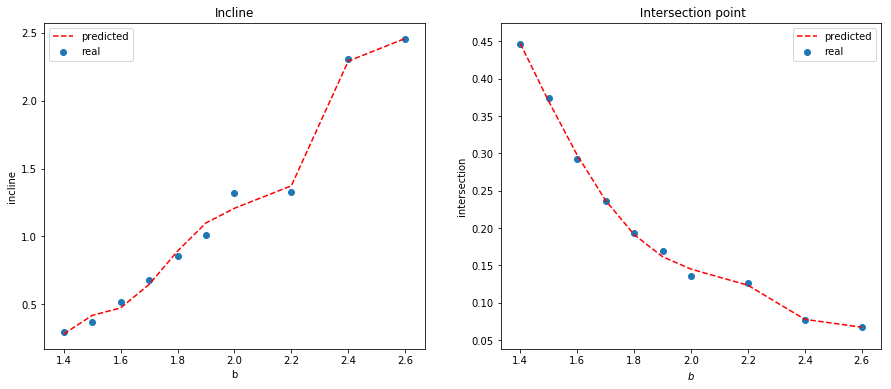

_______________________________________________________
Degree:  7
Параметры для tg угла наклона: [   -320.61405964    4321.25541814  -24773.8899057    78319.45937498
 -147468.59804781  165398.81513204 -102328.01049312   26942.21210699]
ERROR  для tg угла наклона :  0.006522460334367657
Параметры для пересечения с 0: [    27.51958668   -376.65620041   2194.47470651  -7055.13148469
  13517.14681918 -15432.62567554   9719.98917182  -2604.10912681]
ERROR для пересечения с 0:  3.869154064824587e-05


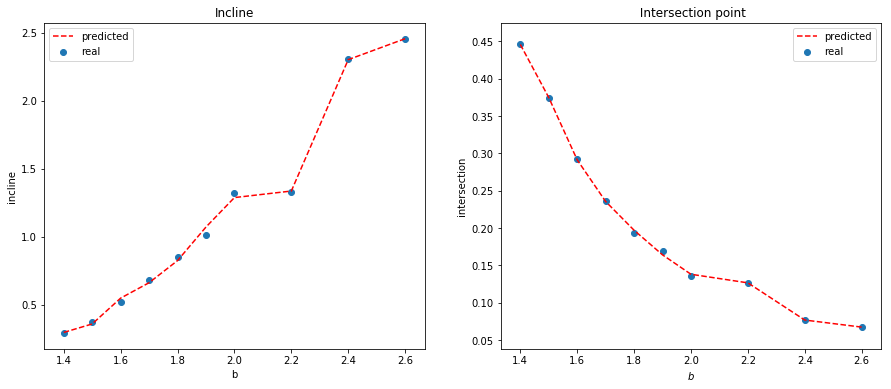

_______________________________________________________
Degree:  8
Параметры для tg угла наклона: [-1.17830351e+03  1.79866506e+04 -1.19357921e+05  4.49748735e+05
 -1.05257792e+06  1.56688379e+06 -1.44894619e+06  7.61060771e+05
 -1.73857217e+05]
ERROR  для tg угла наклона :  0.00116280558213883
Параметры для пересечения с 0: [ 7.24986550e+01 -1.09888974e+03  7.23307580e+03 -2.70019520e+04
  6.25267190e+04 -9.19635218e+04  8.38947893e+04 -4.34025933e+04
  9.75067757e+03]
ERROR для пересечения с 0:  1.8401526270524184e-05


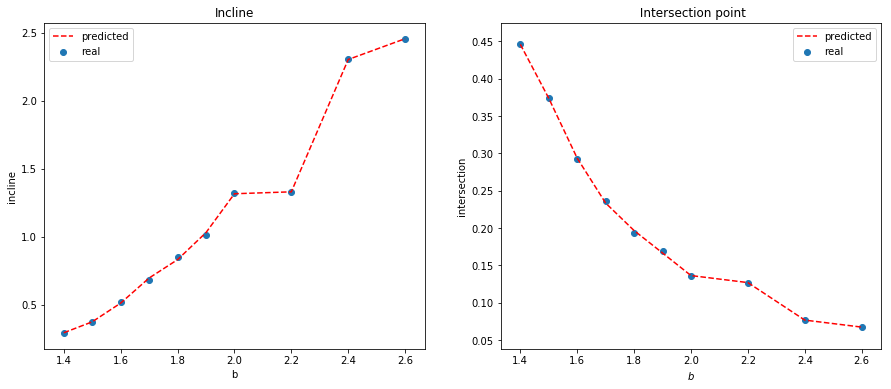

_______________________________________________________
Degree:  9
Параметры для tg угла наклона: [-5.77955237e+03  9.88878924e+04 -7.48113807e+05  3.28471779e+06
 -9.22495497e+06  1.71867477e+07 -2.12432078e+07  1.67989859e+07
 -7.71291731e+06  1.56661019e+06]
ERROR  для tg угла наклона :  2.947578189355312e-14
Параметры для пересечения с 0: [ 7.27055491e+02 -1.25156176e+04  9.52749311e+04 -4.20992465e+05
  1.19005536e+06 -2.23194195e+06  2.77749786e+06 -2.21165656e+06
  1.02260596e+06 -2.09196449e+05]
ERROR для пересечения с 0:  2.39381952133655e-15


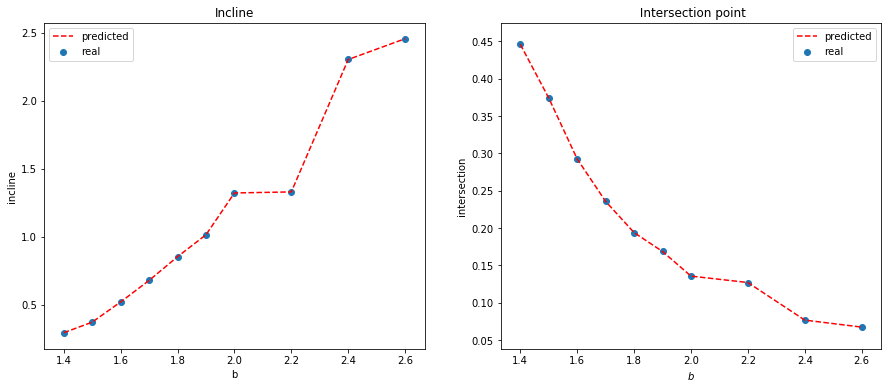

In [144]:
ERR_incl = []
ERR_intersect = []
for degree in xrange(10):
    print "_______________________________________________________"
    print "Degree: ", degree
    
    intersection_gamma= np.array(intersection_gamma)
    incline_gamma= np.array(incline_gamma)
    plt.figure(1, figsize=(15,6))

    plt.subplot(121)
    plt.scatter(arr_b[border:], incline_gamma[border:], label = "real")
    
    # предсказываем
    fit = np.polyfit(arr_b[border:],incline_gamma[border:],degree)
    fit_fn = np.poly1d(fit) 
    plt.plot(arr_b[border:], fit_fn(arr_b[border:]), 'r--', label = "predicted")
    print "Параметры для tg угла наклона:", fit
    print "ERROR  для tg угла наклона : ", np.sum((fit_fn(arr_b[border:]) - incline_gamma[border:])**2) 
    ERR_incl.append(np.sum((fit_fn(arr_b[border:]) - incline_gamma[border:])**2) )
    #plt.plot(arr_b[:border], np.log(2 * incline_gamma[:border]), 'r--')
    plt.xlabel('b')
    plt.ylabel('incline')    
    plt.title('Incline')
    plt.legend()

    plt.subplot(122)
    plt.scatter(arr_b[border:], intersection_gamma[border:], label = "real")
    # предсказываем
    fit = np.polyfit(arr_b[border:],intersection_gamma[border:],degree)
    fit_fn = np.poly1d(fit) 
    plt.plot(arr_b[border:], fit_fn(arr_b[border:]), 'r--', label = "predicted")
    print "Параметры для пересечения с 0:", fit
    print "ERROR для пересечения с 0: ", np.sum((fit_fn(arr_b[border:]) - intersection_gamma[border:])**2) 
    ERR_intersect.append(np.sum((fit_fn(arr_b[border:]) - intersection_gamma[border:])**2) )
    #plt.plot(arr_b[:border], np.log(5 * intersection_gamma[:border]), 'r--')
    plt.legend()



    
    plt.xlabel('$b$')
    plt.ylabel('intersection')    
    plt.title(' Intersection point')
    plt.show()

### Графики ошиок

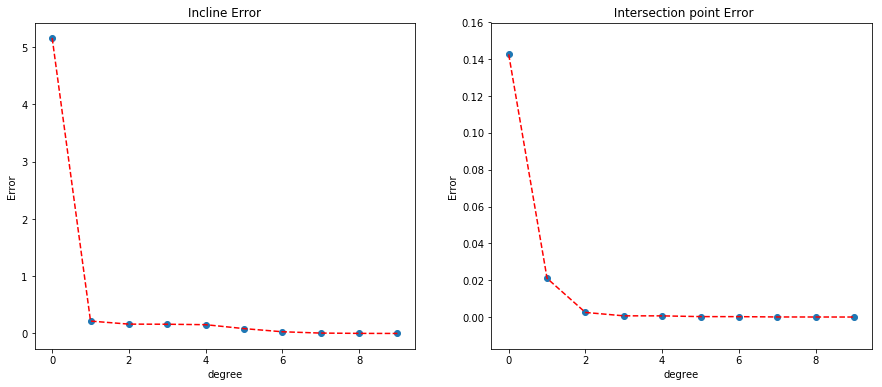

In [145]:
plt.figure(1, figsize=(15,6))

plt.subplot(121)
plt.scatter(range(10), ERR_incl, label = "real")
plt.plot(range(10), ERR_incl, 'r--', label = "predicted")

plt.xlabel('degree')
plt.ylabel('Error')    
plt.title('Incline Error')


plt.subplot(122)
plt.scatter(range(10), ERR_intersect, label = "real")
plt.plot(range(10), ERR_intersect, 'r--', label = "predicted")


plt.xlabel('degree')
plt.ylabel('Error')    
plt.title(' Intersection point Error')

plt.show()

#### Посмотрим ошибки без 0 степени 

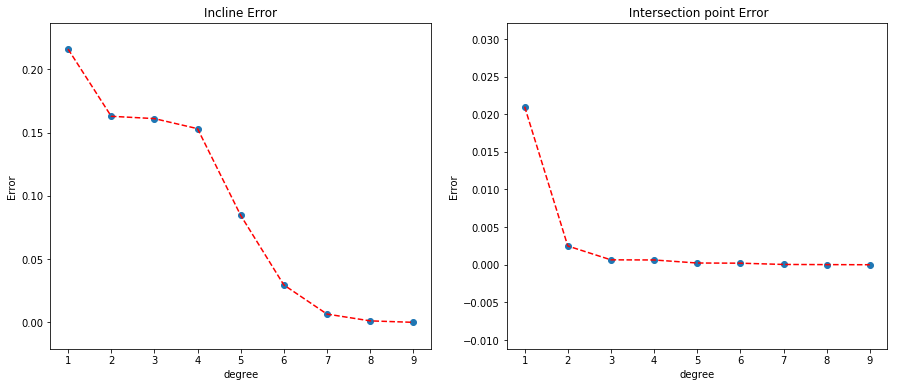

In [148]:

plt.figure(1, figsize=(15,6))

plt.subplot(121)
plt.scatter(range(1,10), ERR_incl[1:], label = "real")
plt.plot(range(1,10), ERR_incl[1:], 'r--', label = "predicted")

plt.xlabel('degree')
plt.ylabel('Error')    
plt.title('Incline Error')

plt.subplot(122)
plt.scatter(range(1,10), ERR_intersect[1:], label = "real")
plt.plot(range(1,10), ERR_intersect[1:], 'r--', label = "predicted")

plt.xlabel('degree')
plt.ylabel('Error')    
plt.title(' Intersection point Error')
plt.show()

### Выводы:
    1. Заметно, что качественное улучшение наклона имеется при степенях 1, 2 далее от 4 до 7;
    2. Качественное улучшение предсказания точки пересечения имеется при степени 2.

# Выводы:
Попробуем предсказывать параметр $\gamma$ от $b(c_r)$ с помощью кусочной функции: 

1. $c_r$ больше $c_r$ max, тогда $\gamma = 0$;
2. $c_r$ меньше $c_r$ max и $b > b_{border}$, $\gamma = k_1 \cdot b + t_1$ где $k_1$ и $\gamma_0$ -- функции первой и второй степени от b соответственно, $t = -k \cdot \gamma_0$;
3. $c_r$ меньше $c_r$ max и $b \le b_{border}$, $\gamma = k_2 \cdot b + t_2$, где $k_2$ и $\gamma_0$ -- функции третей степени от b , $t = -k \cdot \gamma_0$;

$\gamma_0$ --- точка пересечение прямой с 0.